<a href="https://colab.research.google.com/github/charlesdgburns/maze_grid_cells/blob/main/Stachenfeld_representations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Successor Representation

In this notebook we focus on implementing the successor representation (SR) hypothesis of grid cells, as put forward by Stachenfeld et al., (2014; 2017).

In brief, grid cells may be encoding a compressed representation (low-dimensional basis set) of state transitions in a given space. Recall that a state probability transition matrix encodes conditional probabilities between different states $S_i$.

$$ T = \begin{pmatrix}
P(S_1|S_1) &P(S_1|S_2) &\cdots &P(S_1|S_N) \\
P(S_2|S_1) &P(S_2|S_2) &\cdots &P(S_2|S_N) \\
\cdots &\cdots &\cdots &\cdots \\
P(S_N|S_1) &P(S_N|S_2) &\cdots & P(S_N|S_N)
\end{pmatrix} $$

If the policy is a random walk (allowing standing still), we have an even distribution and can obtain our matrix by simply dividing by the column sum of an adjacency matrix with each node being self-connected.

According to Stachenfeld et al., 2014 (citing Dayan, 1993), we should obtain the successor representation by $M=(I - \gamma T)^{-1}$, where $\gamma$ is a discount factor.

Note, however, that we can further specify policies and have a transition matrix which accounts for actions:
$$ T(s,s')=\sum_a \pi(a|s)P(s'|s,a) $$
where $s'$ is a future state transitioned from current state $s$, $P(s'|s,a)$ is either 0 or 1 given that each action either leads to a valid transition or not, and the **random walk** is encoded by $\pi(a|s)=1/d$ where $d$ is the number of valid transitions from state $s$ (in the maze this is the degree of a self-connected node). For example, the transition from $S_1$ to itself under a random walk will be equal to the sum over all possible actions from $S_1$ to itself, of which there is only 1 (not counting loops over a sequence of actions):

$$ T(S_1,S_1)=P(S_1|S_1)=\sum_a \pi(a|S_1)P(S_1|S_1,a) = 1/d. $$

In the successor representation our discount factor $\gamma$ will diffuse the probability of transitions to account for e.g. loops from $S_1$ to itself, based on how far in the future we discount.


# Setup

In [4]:
#Google colab setup:

#Mount google drive first.
from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/Colab Notebooks/Burns/'

#Importing files from Peter Doohan's maze codebase:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Doohan')

import representations as mr
import plotting as mp

#Note that functions and packages e.g. plt and nx will be retrievable under plotting

ModuleNotFoundError: No module named 'google'

In [8]:
# SWC-HPC setup:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from GridMaze.maze import representations as mr
from GridMaze.maze import plotting as mp

from pathlib import Path
save_dir = Path('../GridModels/figures')

In [ ]:
# Options
maze_name = 'fully_connected' #Choose your maze! This is as encoded in the experiment_info.json file.
n_PCs = 101 #Choose the number of principle components to extract. These are ordered in terms of variance explained ratio.
discount_factor = 0.5 #Choosing a discount factor. 0.95 is similar to discretisation in supp. figures Stachenfeld 2017.
with_edges = True #Choose scale: FALSE for Coarse (7x7 grid of nodes) or TRUE for finer-scale (13x13 grid, including edges)

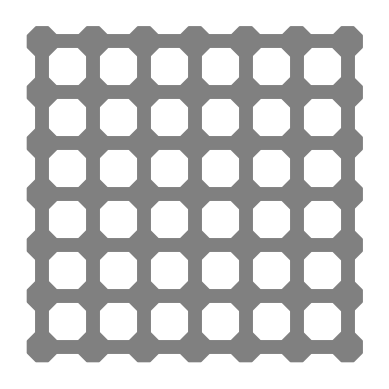

In [ ]:
maze = mr.get_simple_maze(maze_name)

fig, ax = mp.plt.subplots()

mp.plot_simple_maze_silhouette(maze, ax=ax, color='gray')

# Simple predictions

Below we generate a simple set of predictions on either coarse-scale (7x7 node grid) or finer-scale (13x13 grid, including edges). We do both and perform some comparison analyses.

We choose a simple policy where each possible future state is equally likely and discounted.

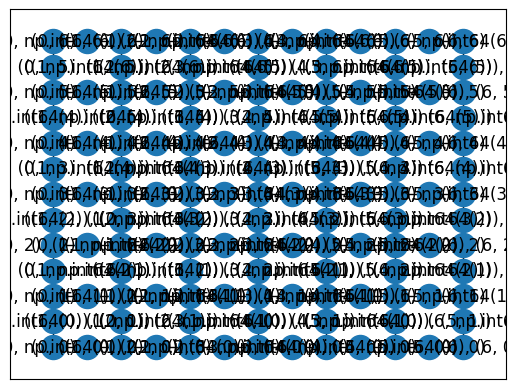

In [ ]:
#Load maze
maze = mr.get_simple_maze(maze_number)

maze_fine = mr.get_extended_simple_maze(maze) #we need the finer-scale for plotting heatmaps in either case.

if with_edges == True:
  maze = maze_fine

#Plot maze to check it's the right one
position = mp.nx.get_node_attributes(maze, 'position') #We need to extract positions for plotting
mp.nx.draw_networkx(maze, position) #Simple nx plot, including the position labels.


## Successor representation matrix

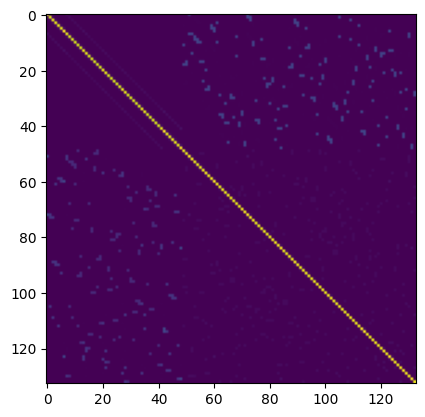

In [ ]:
#Random walk successor representation

#First we take an adjacency matrix and add the possibility of standing still (identity) to get all possible transitions:
adjacency = mp.nx.adjacency_matrix(maze).toarray() #store adjacency in an array
norm_adjacency = adjacency/max(adjacency.flatten()) #normalise so that all adjacency values are 1.
mp.np.fill_diagonal(norm_adjacency,1) #has no output, but makes all diagonals equal to 1, so standing still is a valid transition

#Then we want to implement random walk policy, making each possible transition equally likely
for c in range(mp.np.size(adjacency[:][0])): #for each column
  norm_adjacency[:,c] = norm_adjacency[:,c]/sum(norm_adjacency[:,c]) #make each column a probability over transitions. Remember we index by [row,column].

T_matrix = norm_adjacency #Renaming after the above

#Compute successor representation, by the inverse of I-gT
temp_matrix =  mp.np.identity(T_matrix.shape[1])-discount_factor*T_matrix #(I - gammaT)^-1, so gamma here is discount factor defined above.
SR_matrix = mp.np.linalg.inv(temp_matrix) #Final output!

#Optional matrix plotting to check all is ok:
#plotting.plt.imshow(T_matrix)
mp.plt.imshow(SR_matrix)

### Place-cell checkpoint

Below we're plotting the rows of the SR matrix, which should roughly correspond to place cells.



KeyboardInterrupt: 

<Figure size 3000x3000 with 0 Axes>

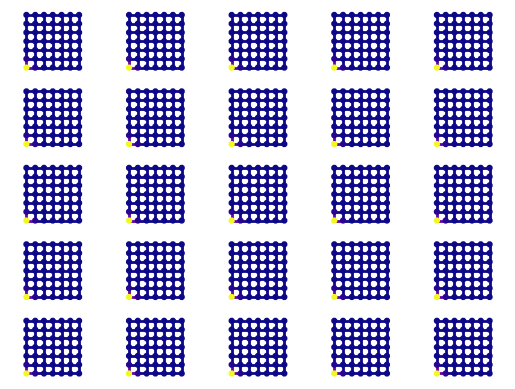

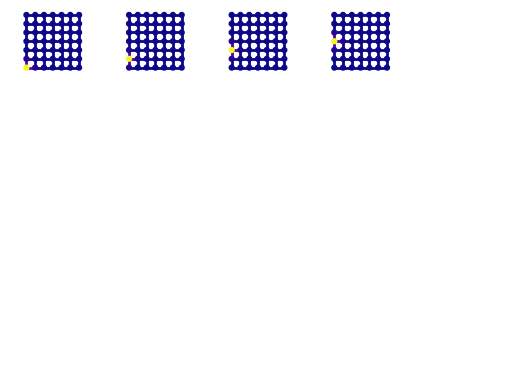

In [ ]:
#Plot SR place cells:

#We're plotting with Peter's plot_simple_heatmap function
#This requires a colour value for each edge encoded in a pandas series with SR_matrix values indexed by a label:
label = mp.nx.get_node_attributes(maze_fine, 'label').values()

mp.plt.figure(figsize=(10, 10), dpi=300)

# Here we plot the columns in sets of 25

for each_set in range(round(n_PCs/25)): #For each set of 25 columns of the SR_matrix / place cell we want to plot.
  fig, axs = mp.plt.subplots() #Make a big figure for each set of 25 plots
  axs.axis('off')
  for plot in range(25): #plot each in a 5x5 panel:
    plot_position = plot+1 #must be integer between 1 and 25.
    ax = fig.add_subplot(5,5,plot_position)
    ax.set_aspect('equal')
    ax.axis('off')

    value = SR_matrix[:,plot*(each_set*1)] #Extract the column which we want to plot. This is a multiple of 25 for each set.
    #if we're on the small maze, we want the colour value of edges to map to 0.
    if with_edges==False:
      value = mp.np.pad(value, (0, maze.number_of_edges()), 'constant') #SR matrix only has values for each node, so now we put a 0 for each edge.

    values = mp.pd.Series(data=value, index=label)
    values.index.name='maze_position' #required for the plot function to work

    mp.plot_simple_heatmap(mr.get_simple_maze(maze_number), #We need to map onto the 'small' maze.
                          values,
                          ax,
                          node_size = 10, #these dimensions work with a panel of 25
                          edge_size = 2, #dimension works with a panel of 25
                          value_label='',
                          title='')

## Principal Component Analysis (PCA)

Here we perform PCA to extract an eigendecomposition of the SR matrix which is ordered according to explained variance.

In [ ]:
from sklearn.decomposition import PCA

pca_SR = PCA(n_components = n_PCs)

SR_components = pca_SR.fit_transform(SR_matrix) #Perform PCA on SR matrix

if with_edges == False:
  SR_components = mp.np.pad(SR_components, (0, maze.number_of_edges()), 'constant') #since we plot onto maze with edges, when they're excluded we want them to have a value of 0.

varExp = mp.np.ceil(pca_SR.explained_variance_ratio_*1000)/10 #Extracting variance explained as a percentage

<Figure size 3000x3000 with 0 Axes>

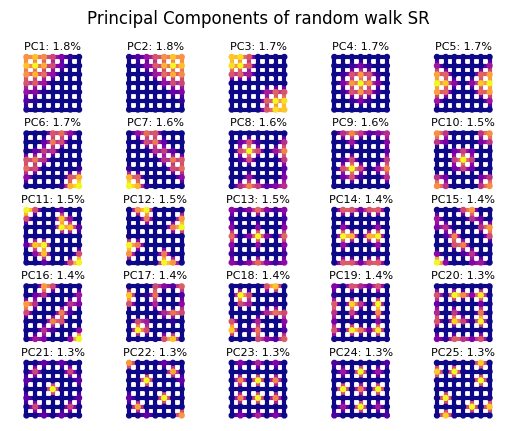

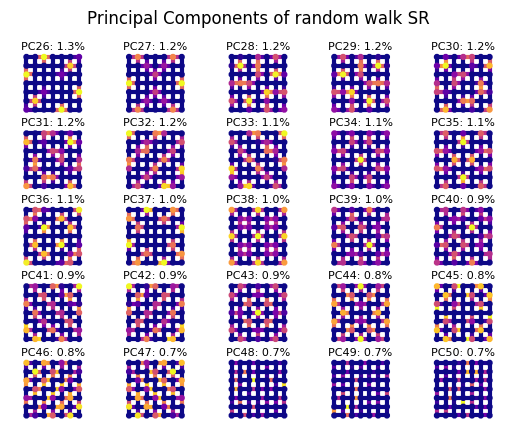

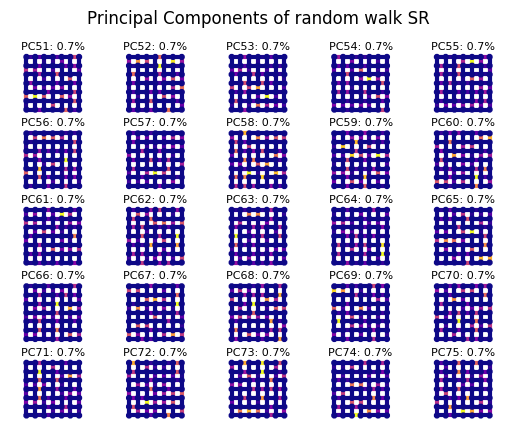

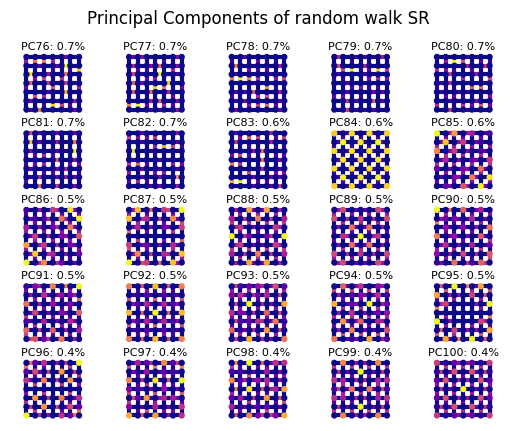

In [ ]:
#Plotting PCs
#We're plotting with Peter's plot_simple_heatmap function
#This requires a colour value for each edge encoded in a pandas series with SR_matrix values indexed by a label:
label = mp.nx.get_node_attributes(maze_fine, 'label').values()
mp.plt.figure(figsize=(10, 10), dpi=300)

for each_set in range(round(n_PCs/25)): #For each set of 25 columns of the SR_matrix / place cell we want to plot.
  SR_fig, axs = mp.plt.subplots()
  axs.axis('off')
  axs.set_title('Principal Components of random walk SR', pad = 20)
  for plot in range(25): #plot each in a 5x5 panel:
    plot_position = plot+1 #must be integer between 1 and 25.
    ax = SR_fig.add_subplot(5,5,plot_position)
    ax.set_aspect('equal')
    ax.axis('off')

    PCA_no = 25*each_set+plot+1

    value = SR_components[:,PCA_no-1] #Extract the column which we want to plot, this is PCA number -1 because indexing starts at 0.
    values = mp.pd.Series(data=value, index=label) #Put data in the right format for plot_simple_heatmap
    values.index.name='maze_position' #Further required for the plot function to work
    mp.plot_simple_heatmap(mr.get_simple_maze(maze_number), #We need to map onto the 'small' maze.
                          values,
                          ax,
                          node_size = 10,
                          edge_size = 3,
                          value_label='',
                          title='')
    subplot_title ='PC'+str(PCA_no)+': '+str(varExp[PCA_no])+'%'
    ax.set_title(label=str(subplot_title), fontdict={'fontsize': 8}, pad=-2)


In [ ]:
#Plot a single PC in HD

SR_fig, ax = mp.plt.subplots()
ax.axis('off')
ax.set_aspect('equal')
ax.axis('off')

value = SR_components[:,8] #Extract the column which we want to plot.

values = mp.pd.Series(data=value, index=label) #Put data in the right format for plot_simple_heatmap

values.index.name='maze_position' #Further required for the plot function to work

mp.plot_simple_heatmap(mr.get_simple_maze(maze_number), #We need to map onto the 'small' maze.
                         values,
                         ax,
                         node_size = 500,
                         edge_size = 10,
                         value_label='',
                         title='PC'+str(8+1)+': '+str(varExp[8])+'%')

## Save Files

In [ ]:
#We save the PCA components. Pandas series similar to how its plotted, for later joining by index.
#If edges excluded, we must add 0s for the labels.
label = mp.nx.get_node_attributes(maze_fine, 'label').values()

filename = save_dir+'/data/SR_maze'+str(maze_number)+'_'+str(n_PCs)+'PC_g'+str(discount_factor)
figurename = save_dir+'/figures/SR_maze'+str(maze_number)+'_'+str(n_PCs)+'PC_g'+str(discount_factor)

if with_edges == False:
  filename = filename+'_WITHOUT_edges'
  figurename = figurename+'_WITHOUT_edges'

dataframe = mp.pd.DataFrame(data=SR_components, index=label)


#Saving files
dataframe.to_csv(filename+'.csv') #prediction stored in a pandas dataframe with maze labels as

SR_fig.savefig(figurename+'.png')


# Directional predictions

Here we want to expand our state-space to include four head-directions at each node and bridge.

Initialising from a random walk, we then also want to update the SR for each step along a series of transitions (e.g. over all 8 maze sessions).

In [ ]:
maze = mr.get_simple_maze('P1')

mr.get_maze_place_direction_pairs(maze)


[('A1', 'N'),
 ('A2', 'S'),
 ('A2', 'E'),
 ('A3', 'N'),
 ('A3', 'E'),
 ('A4', 'S'),
 ('A4', 'N'),
 ('A5', 'S'),
 ('A5', 'N'),
 ('A5', 'E'),
 ('A6', 'S'),
 ('A6', 'N'),
 ('A7', 'S'),
 ('A7', 'E'),
 ('B1', 'E'),
 ('B2', 'W'),
 ('B2', 'E'),
 ('B3', 'W'),
 ('B3', 'E'),
 ('B4', 'N'),
 ('B5', 'W'),
 ('B5', 'S'),
 ('B6', 'N'),
 ('B6', 'E'),
 ('B7', 'W'),
 ('B7', 'S'),
 ('C1', 'W'),
 ('C1', 'N'),
 ('C2', 'W'),
 ('C2', 'S'),
 ('C2', 'N'),
 ('C2', 'E'),
 ('C3', 'W'),
 ('C3', 'S'),
 ('C3', 'N'),
 ('C4', 'S'),
 ('C4', 'N'),
 ('C5', 'S'),
 ('C5', 'N'),
 ('C5', 'E'),
 ('C6', 'W'),
 ('C6', 'S'),
 ('C6', 'N'),
 ('C7', 'S'),
 ('C7', 'E'),
 ('D1', 'N'),
 ('D1', 'E'),
 ('D2', 'W'),
 ('D2', 'S'),
 ('D2', 'E'),
 ('D3', 'N'),
 ('D3', 'E'),
 ('D4', 'S'),
 ('D4', 'N'),
 ('D4', 'E'),
 ('D5', 'W'),
 ('D5', 'S'),
 ('D5', 'E'),
 ('D6', 'N'),
 ('D6', 'E'),
 ('D7', 'W'),
 ('D7', 'S'),
 ('E1', 'W'),
 ('E2', 'W'),
 ('E2', 'E'),
 ('E3', 'W'),
 ('E3', 'E'),
 ('E4', 'W'),
 ('E5', 'W'),
 ('E5', 'E'),
 ('E6', 'W'),
 ('E6'

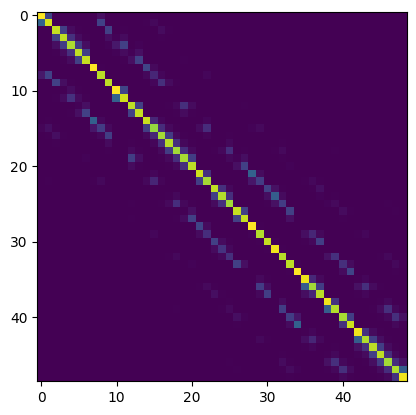

In [ ]:
#Generating a transition matrix with all four directions is not trivial.

#We borrow Peter's representation, where each tower is connected by two one-directional bridges.
#Trajectory can then be discretised into states and from states to transitions

test = maze.to_directed()

#Random walk successor representation for an undirected matrix.
#Adjacency matrix would only look different if we split each bridge into two different states
#(one for each direction of crossing)

#First we take an adjacency matrix and add the possibility of standing still (identity) to get all possible transitions:
adjacency = mp.nx.adjacency_matrix(test).toarray() #store adjacency in an array
norm_adjacency = adjacency/max(adjacency.flatten()) #normalise so that all adjacency values are 1.
mp.np.fill_diagonal(norm_adjacency,1) #has no output, but makes all diagonals equal to 1, so standing still is a valid transition

#Then we want to implement random walk policy, making each possible transition equally likely
for c in range(mp.np.size(adjacency[:][0])): #for each column
  norm_adjacency[:,c] = norm_adjacency[:,c]/sum(norm_adjacency[:,c]) #make each column a probability over transitions. Remember we index by [row,column].

T_matrix = norm_adjacency #Renaming after the above

#Compute successor representation, by the inverse of I-gT
temp_matrix =  mp.np.identity(T_matrix.shape[1])-discount_factor*T_matrix #(I - gammaT)^-1, so gamma here is discount factor defined above.
SR_matrix = mp.np.linalg.inv(temp_matrix) #Final output!

#Optional matrix plotting to check all is ok:
#plotting.plt.imshow(T_matrix)
mp.plt.imshow(SR_matrix)

# Much finer-grain state space

Essentially, we want to compare open-field grid-world type eigenvectors with eigenvectors on the maze.



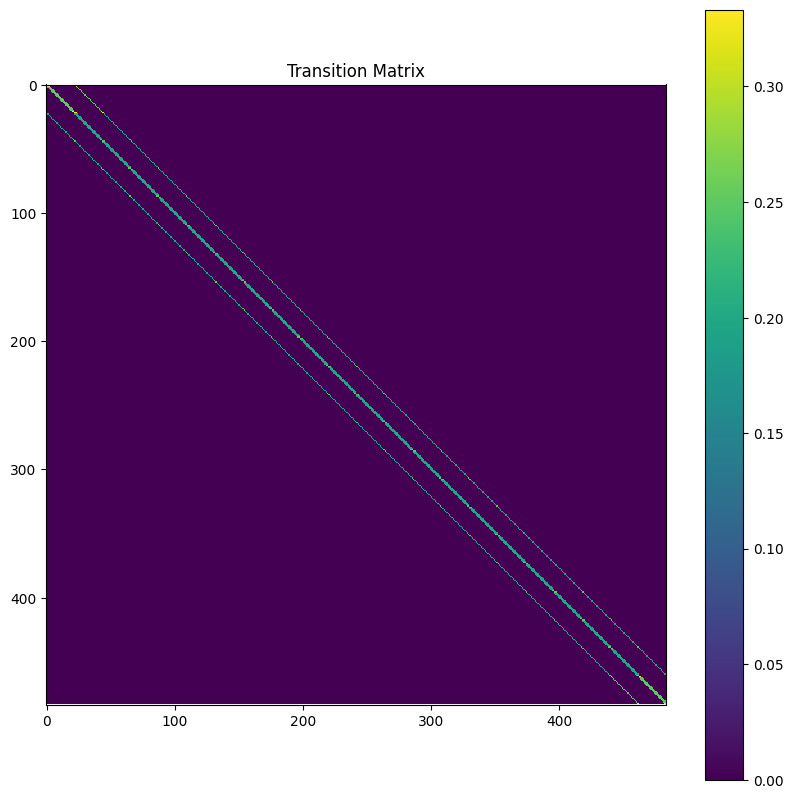

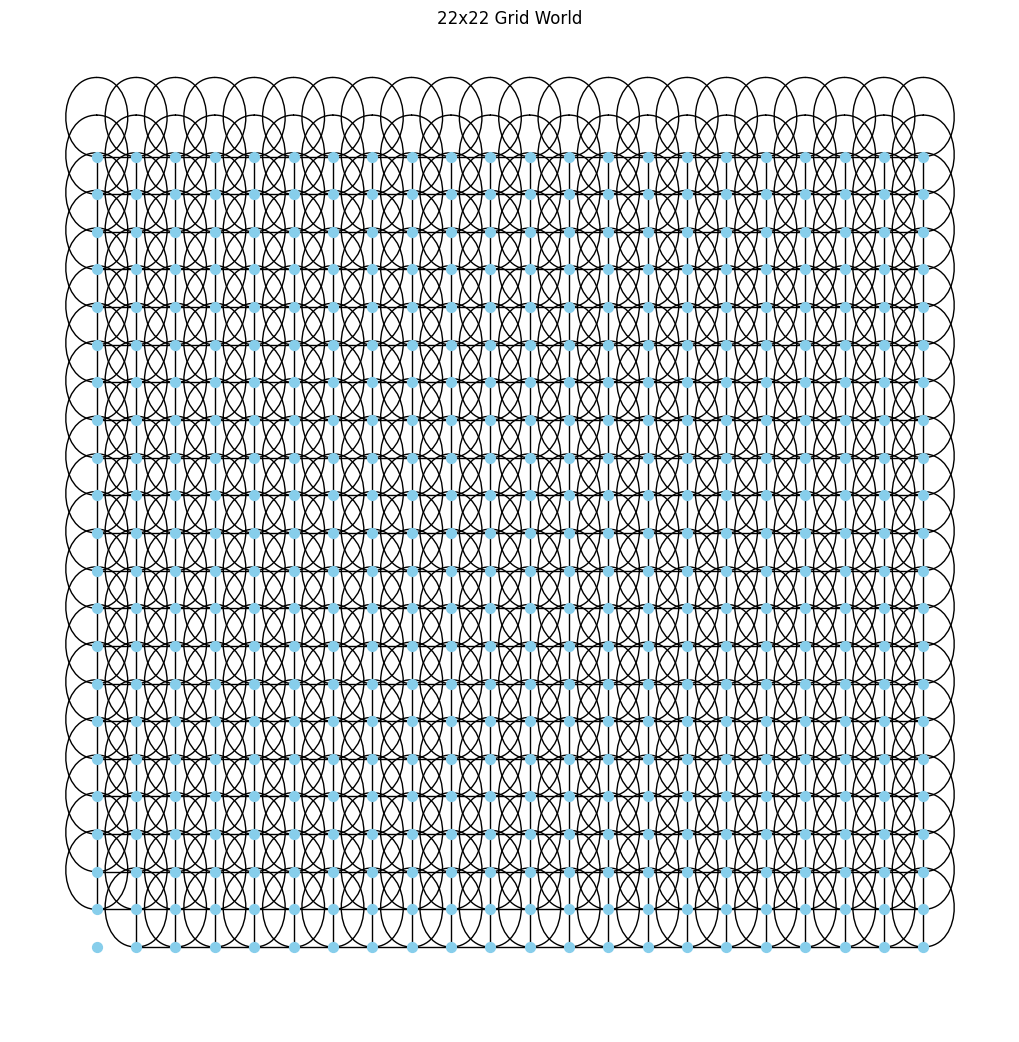

In [ ]:
# prompt: I want to generate a 22x22 bin square world (all 1's) and generate a transition matrix from it, under a random walk policy.
# The possible transitions are standing still, moving North, South, East, or West, unless there is no bin adjacent to it (a 0, NaN, or boundary in the square world)
# This can be represented as a graph, each bin is connected to adjacent bins and itself.
# Can you generate such a graph and the resulting transition matrix and plot it for me?
# Use the Network X package to help starting from grid_2d_graph and removing edges for a node that is 0 in a mask, while also adding recurrent edges from a node to itself to each node.

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create a 22x22 grid graph
grid_size = 22
graph = nx.grid_2d_graph(grid_size, grid_size)

# Create a mask (all 1s for this case)
world = np.ones((grid_size, grid_size))

world[0,0]=0

# Add self-loops and remove edges based on the mask
for node in graph.nodes():
  if world[node]!=1:
    for neighbor in list(graph.neighbors(node)):
          graph.remove_edge(node, neighbor)
    continue
  else:
    graph.add_edge(node, node) #add self-loop to every node

    #remove edges that don't exist based on the mask


# Calculate the transition matrix
adj_matrix = nx.adjacency_matrix(graph).toarray()
transition_matrix = np.zeros_like(adj_matrix, dtype=float)
for i in range(adj_matrix.shape[0]):
  if np.sum(adj_matrix[i,:]) > 0:
    transition_matrix[i,:] = adj_matrix[i,:] / np.sum(adj_matrix[i,:])

#Plot the Transition Matrix
plt.figure(figsize=(10, 10))
plt.imshow(transition_matrix, cmap='viridis', interpolation='nearest')
plt.title('Transition Matrix')
plt.colorbar()
plt.show()

# Plot the graph (optional, for visualization)
plt.figure(figsize=(10, 10))
pos = {(x, y): (x, y) for x, y in graph.nodes()}
nx.draw(graph, pos, node_size=50, node_color='skyblue', with_labels=False)
plt.title('22x22 Grid World')
plt.show()


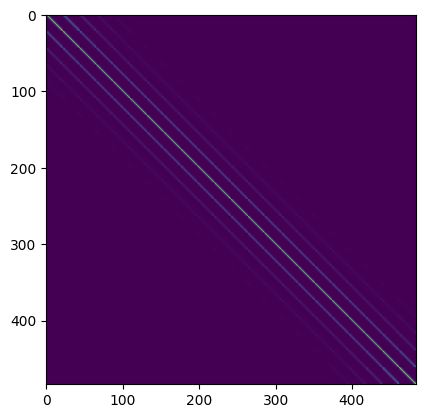

In [ ]:

T_matrix = transition_matrix #Renaming after the above
discount_factor = 0.85
#Compute successor representation, by the inverse of I-gT
temp_matrix =  mp.np.identity(T_matrix.shape[1])-discount_factor*T_matrix #(I - gammaT)^-1, so gamma here is discount factor defined above.
SR_matrix = mp.np.linalg.inv(temp_matrix) #Final output!

#Optional matrix plotting to check all is ok:
#plotting.plt.imshow(T_matrix)
mp.plt.imshow(SR_matrix)

<Figure size 3000x3000 with 0 Axes>

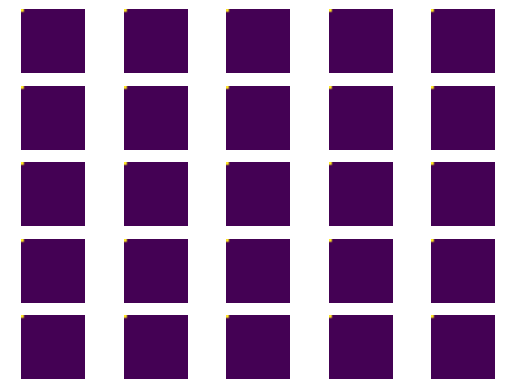

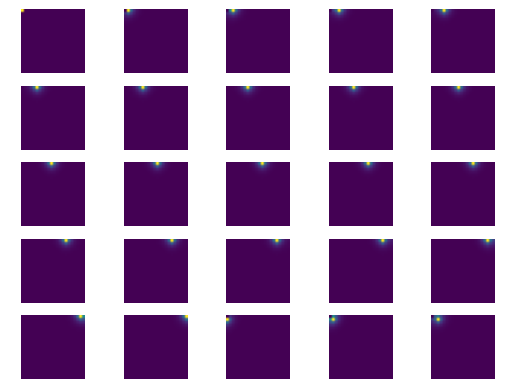

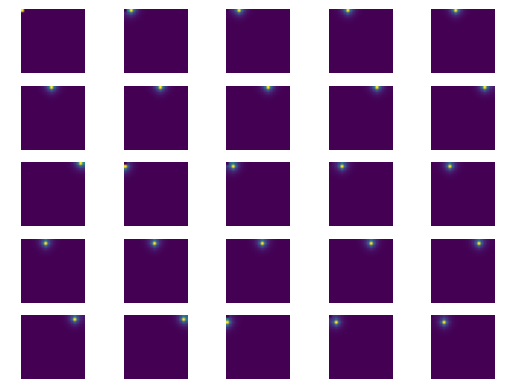

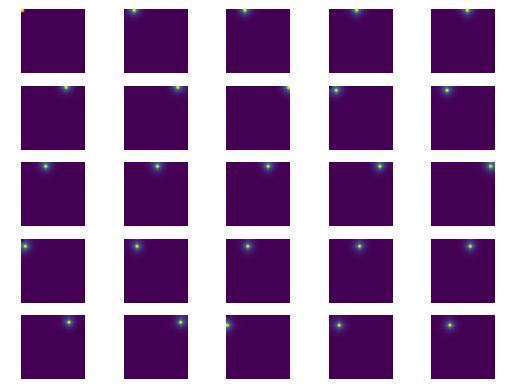

In [ ]:
#Plot SR place cells:
mp.plt.figure(figsize=(10, 10), dpi=300)

# Here we plot the columns in sets of 25

for each_set in range(round(n_PCs/25)): #For each set of 25 columns of the SR_matrix / place cell we want to plot.
  fig, axs = mp.plt.subplots() #Make a big figure for each set of 25 plots
  axs.axis('off')
  for plot in range(25): #plot each in a 5x5 panel:
    plot_position = plot+1 #must be integer between 1 and 25.
    ax = fig.add_subplot(5,5,plot_position)
    ax.set_aspect('equal')
    ax.axis('off')

    value = SR_matrix[:,plot*(each_set*1)] #Extract the column which we want to plot. This is a multiple of 25 for each set.
    ax.imshow(value.reshape(world.shape))


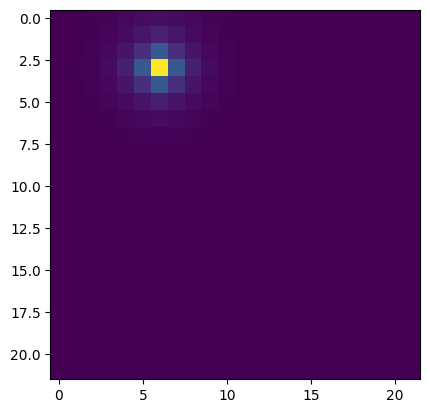

In [ ]:
plt.imshow(value.reshape(world.shape))

In [ ]:
from sklearn.decomposition import PCA
n_PCs = 200
pca_SR = PCA(n_components = n_PCs)

SR_components = pca_SR.fit_transform(SR_matrix) #Perform PCA on SR matrix

if with_edges == False:
  SR_components = mp.np.pad(SR_components, (0, maze.number_of_edges()), 'constant') #since we plot onto maze with edges, when they're excluded we want them to have a value of 0.

varExp = mp.np.ceil(pca_SR.explained_variance_ratio_*1000)/10 #Extracting variance explained as a percentage

<Figure size 3000x3000 with 0 Axes>

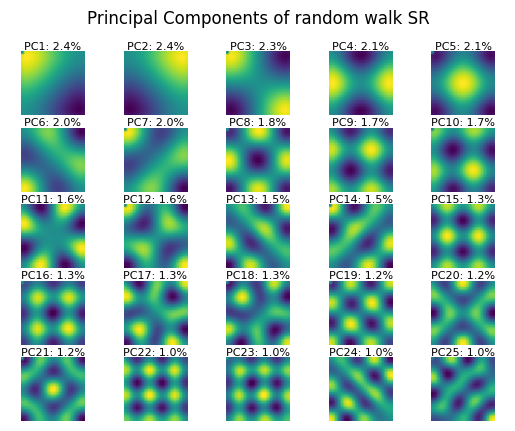

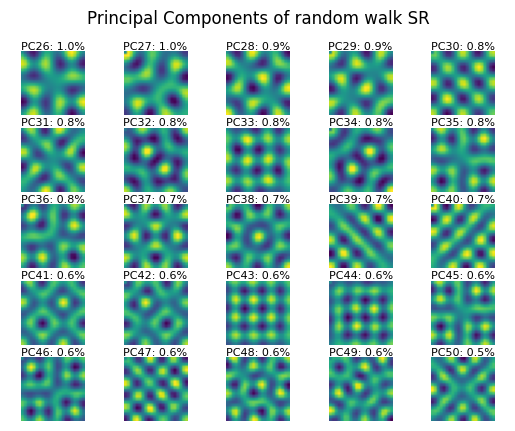

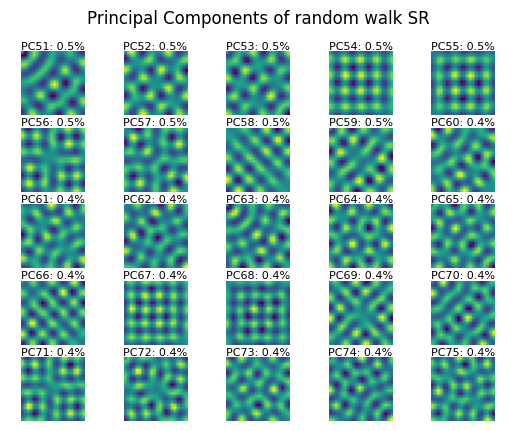

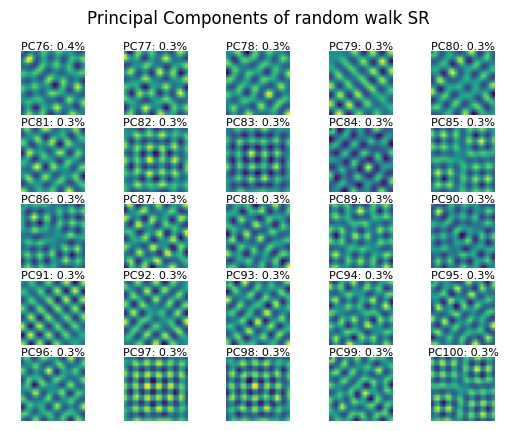

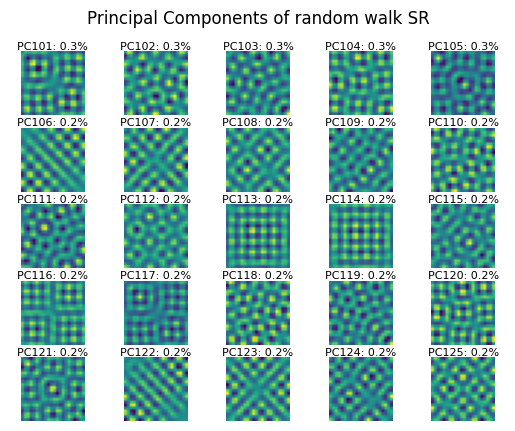

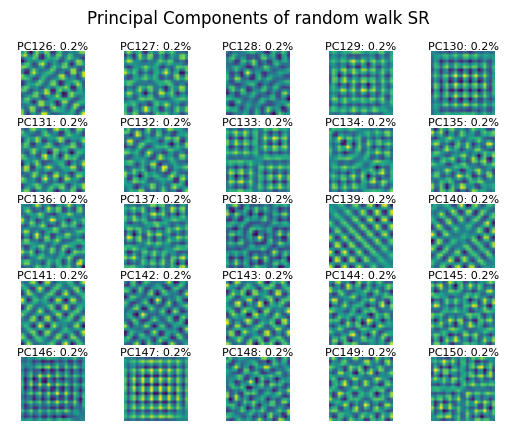

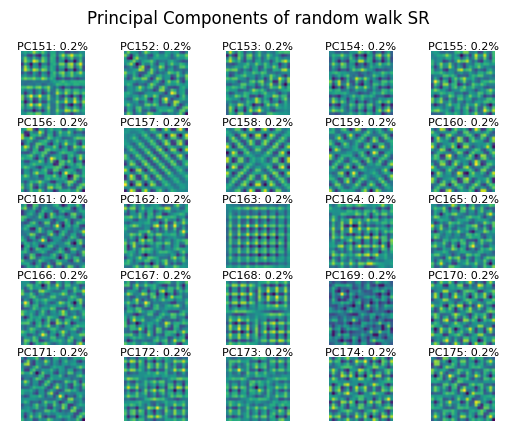

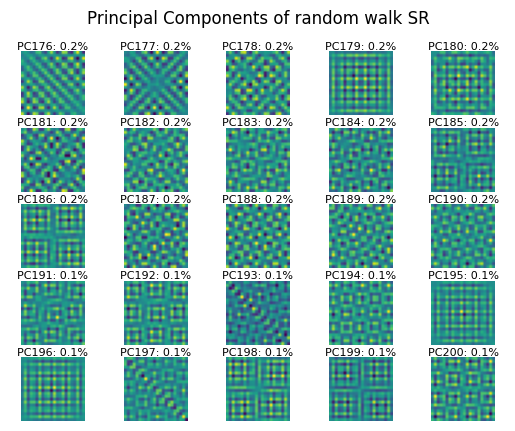

In [ ]:
#Plotting PCs
#We're plotting with Peter's plot_simple_heatmap function
#This requires a colour value for each edge encoded in a pandas series with SR_matrix values indexed by a label:
#label = mp.nx.get_node_attributes(maze_fine, 'label').values()
plt.figure(figsize=(10, 10), dpi=300)

for each_set in range(round(n_PCs/25)): #For each set of 25 columns of the SR_matrix / place cell we want to plot.
  SR_fig, axs = plt.subplots()
  axs.axis('off')
  axs.set_title('Principal Components of random walk SR', pad = 20)
  for plot in range(25): #plot each in a 5x5 panel:
    plot_position = plot+1 #must be integer between 1 and 25.
    ax = SR_fig.add_subplot(5,5,plot_position)
    ax.set_aspect('equal')
    ax.axis('off')

    PCA_no = 25*each_set+plot+1

    value = SR_components[:,PCA_no-1] #Extract the column which we want to plot, this is PCA number -1 because indexing starts at 0.
    ax.imshow(value.reshape(world.shape))
    subplot_title ='PC'+str(PCA_no)+': '+str(varExp[PCA_no-1])+'%'
    ax.set_title(label=str(subplot_title), fontdict={'fontsize': 8}, pad=-2)


# Real data

Here we do some test on real data.
We can use real data to bin spatial locations into a much finer transition matrix.

We can also 

In [47]:
np.random.uniform(size = (10,2))

array([[0.03177351, 0.36525629],
       [0.11302529, 0.03006712],
       [0.66941736, 0.84565614],
       [0.53547958, 0.36006046],
       [0.9262876 , 0.16112613],
       [0.43364003, 0.68167847],
       [0.84151024, 0.87963664],
       [0.45359059, 0.70855025],
       [0.8119006 , 0.43343543],
       [0.13085207, 0.12284308]])

In [ ]:


%load_ext autoreload
from GridMaze.analysis.core import get_sessions as gs
from GridMaze.analysis.cluster_tuning import spatial
from GridModels.code.measures import SR_maze as SR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Fine-scale (binned)
Here we want to use trajectory data to bin the spatial locations such that we get a finer SR representation.

- it is harder (more data limited) to estimate policy effects on this fine-scale SR.

91.39999999999989


<Figure size 3000x3000 with 0 Axes>

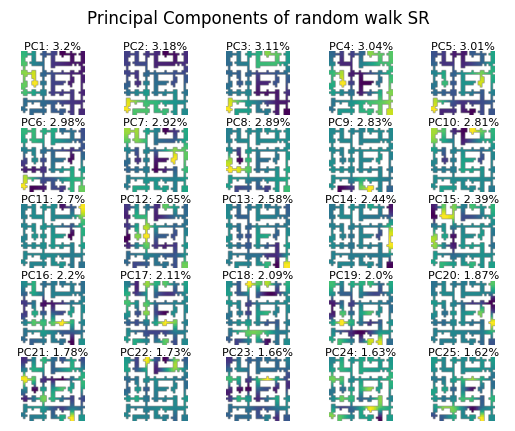

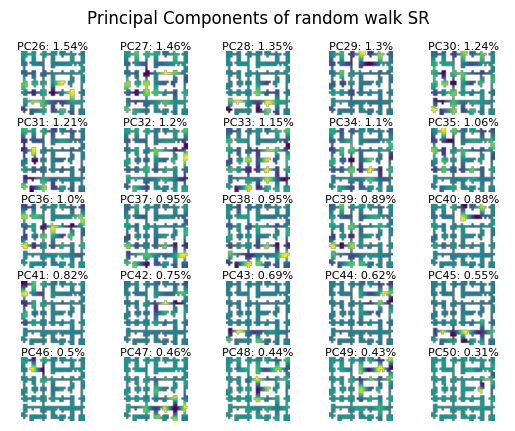

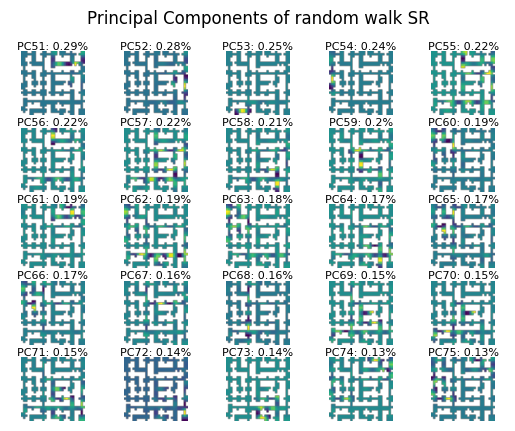

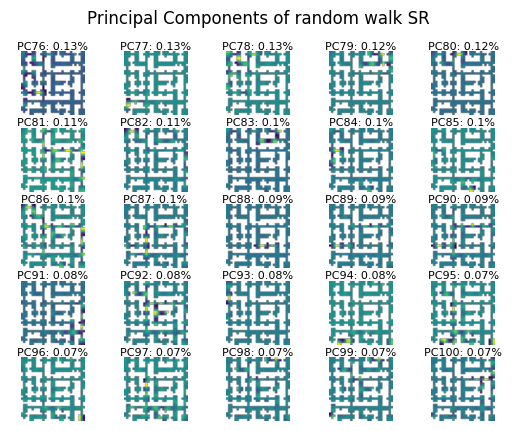

In [44]:
# On binned real data binned
maze_session = gs.get_maze_sessions(['mEC_5'],['maze_1'],[1],with_data=['navigation_df'])
positions = maze_session.navigation_df.centroid_position.values
bin_mask, binx, biny = spatial.get_2D_ratemap(np.ones(len(positions)),
                                              positions,
                                              x_size = 0.04,
                                              y_size = 0.04)
bin_mask[bin_mask>0] = 1

SR_matrix, binned_maze = SR.get_SR_from_bin_mask(bin_mask, discount_factor = 0.95)
SR_components, varExp = SR.get_SR_components(SR_matrix, 101)
SR.plot_binned_SRs(SR_components,varExp,bin_mask)
print(sum(varExp))
#note that binned_maze is a graph object that can be used to compute geodesic distance with finer scale.

### Node-tower scale

Here we want to update the transition matrix using behavioural trajectories from mice under a goal-directed policy.



100.48999999999998


<Figure size 3000x3000 with 0 Axes>

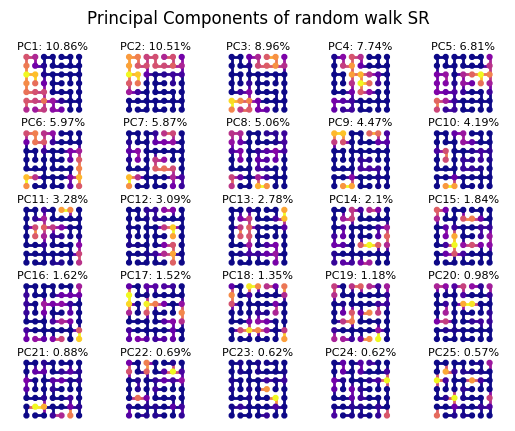

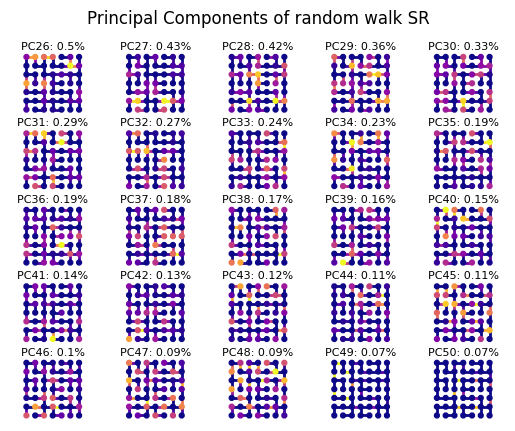

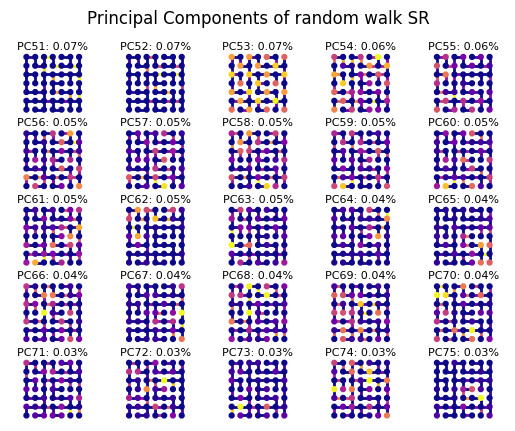

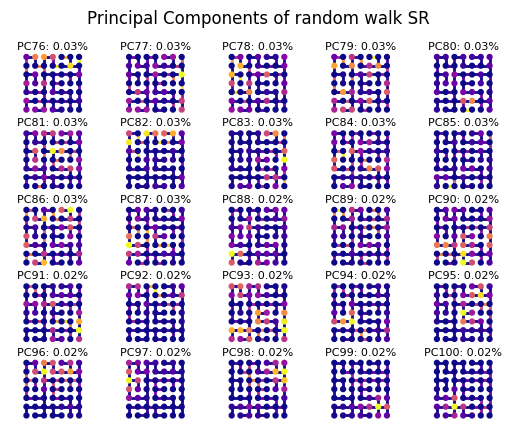

In [45]:
# SR_components can now be treated as heatmaps for analyses.
maze_name = 'maze_1'
sr_matrix = SR.get_maze_SR_df(maze_name, discount_factor = 0.95)
sr_components, variance_explained = SR.get_SR_components(sr_matrix,n_PCs)
SR.plot_maze_SR_components(sr_components,variance_explained,maze_name)
print(sum(variance_explained))

In [ ]:

maze_session = gs.get_maze_sessions(['mEC_5'],['maze_1'],[1],with_data=['navigation_df'])

maze_session.navigation_df.columns

MultiIndex([(                       'time',              ''),
            (               'subject_name',              ''),
            (                  'maze_name',              ''),
            (                'day_on_maze',              ''),
            (            'trial_unique_ID',              ''),
            (                      'trial',              ''),
            (                'trial_phase',              ''),
            (                       'goal',              ''),
            (             'head_direction',         'value'),
            (          'centroid_position',             'x'),
            (          'centroid_position',             'y'),
            (              'maze_position',        'simple'),
            (              'maze_position',      'skeleton'),
            (                   'velocity',             'x'),
            (                   'velocity',             'y'),
            (                      'speed',              ''),
        

In [ ]:
nav_df = maze_session.navigation_df
#we one-hot encode cardinal direction
NSEW2idx = {'N':0,'S':1,'E':2,'W':3, 'nan':4,np.nan:4}
nav_df[('card_one_hot','')] = nav_df.cardinal_movement_direction.apply(lambda x: np.eye(5)[NSEW2idx[x],:4])
grouped_nav_df = nav_df.groupby([('maze_position','simple')])
transition_means = grouped_nav_df.card_one_hot.mean()

In [ ]:
print(transition_means.index.values)

['A1' 'A1-A2' 'A2' 'A2-B2' 'A3' 'A3-A4' 'A3-B3' 'A4' 'A4-A5' 'A5' 'A5-A6'
 'A5-B5' 'A6' 'A6-A7' 'A7' 'A7-B7' 'B1' 'B1-C1' 'B2' 'B2-C2' 'B3' 'B3-C3'
 'B4' 'B4-B5' 'B5' 'B6' 'B6-B7' 'B6-C6' 'B7' 'C1' 'C1-C2' 'C2' 'C2-C3'
 'C2-D2' 'C3' 'C3-C4' 'C4' 'C4-C5' 'C5' 'C5-C6' 'C5-D5' 'C6' 'C6-C7' 'C7'
 'C7-D7' 'D1' 'D1-D2' 'D1-E1' 'D2' 'D2-E2' 'D3' 'D3-D4' 'D3-E3' 'D4'
 'D4-D5' 'D4-E4' 'D5' 'D5-E5' 'D6' 'D6-D7' 'D6-E6' 'D7' 'E1' 'E2' 'E2-F2'
 'E3' 'E3-F3' 'E4' 'E5' 'E5-F5' 'E6' 'E6-F6' 'E7' 'E7-F7' 'F1' 'F1-F2'
 'F2' 'F2-F3' 'F2-G2' 'F3' 'F4' 'F4-F5' 'F5' 'F5-G5' 'F6' 'F6-F7' 'F6-G6'
 'F7' 'G1' 'G1-G2' 'G2' 'G2-G3' 'G3' 'G3-G4' 'G4' 'G4-G5' 'G5' 'G5-G6'
 'G6' 'G6-G7' 'G7']


In [ ]:
simple_maze = maze_session.simple_maze()
extended_maze = mr.get_extended_simple_maze(simple_maze)
node2label = nx.get_node_attributes(extended_maze,'label')
for each_node in extended_maze.nodes():
    try:
        transition_vector = transition_means[node2label[each_node]]
    except Exception as e:
        print(e)
        continue
    neighbours = extended_maze.neighbors(each_node)
    #print([node2label[x] for x in neighbours])
    #print(transition_vector)#
